# Minimal Trancription/Translation in a Lattice Environment

This notebook introduces the Vivarium interface protocol by working through a simple, qualitative example of transcription/translation, and iterating on model design to add more complexity. It is then put in a spatial Lattice environment and grown into a colony with many cells running in parallel.

In [1]:
# %%capture
# !pip install vivarium-multibody

In [2]:
# Imports and Notebook Utilities
import os
import copy
import pylab as plt
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
import matplotlib

# Process, Deriver, and Composer base classes
from vivarium.core.process import Process, Deriver
from vivarium.core.composer import Composer
from vivarium.core.registry import process_registry

# helper functions for composition
from vivarium.core.composition import (
    simulate_process,
    process_in_experiment,
    composer_in_experiment,
    composite_in_experiment)

# other vivarium imports
from vivarium.core.engine import Engine, pp
from vivarium.library.units import units

# plotting functions
from vivarium.plots.simulation_output import (
    plot_simulation_output, plot_variables)
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology


OUTDIR = 'out/stochastic_expression'
os.makedirs(OUTDIR, exist_ok=True)

AVOGADRO = constants.N_A * 1 / units.mol

store_cmap = matplotlib.cm.get_cmap('Dark2')
dna_color = matplotlib.colors.to_rgba(store_cmap(0))
rna_color = matplotlib.colors.to_rgba(store_cmap(1))
protein_color = matplotlib.colors.to_rgba(store_cmap(2)) 
global_color = matplotlib.colors.to_rgba(store_cmap(7))                             
store_colors = {
    'DNA': dna_color, 
    'DNA\n(counts)': dna_color, 
    'DNA\n(mg/mL)': dna_color, 
    'mRNA': rna_color,
    'mRNA\n(counts)': rna_color,
    'mRNA\n(mg/mL)': rna_color,
    'Protein': protein_color,
    'Protein\n(mg/mL)': protein_color,
    'boundary': global_color}
                       
# plotting configurations
topology_plot_config = {
    'settings': {
        'coordinates': {
            'Tl': (-1,0),
            'Tx': (-1,-1),
            'Protein': (1,0),
            'mRNA': (1,-1),
            'DNA': (1,-2),
        },
        'node_distance': 3.0,
        'process_color': 'k',
        'store_colors': store_colors,
        'dashed_edges': True,
        'graph_format': 'vertical',
        'color_edges': False}, 
    'out_dir': OUTDIR}

plot_var_config = {
    'row_height': 2,
    'row_padding': 0.2,
    'column_width': 10,
    'out_dir': OUTDIR}

stoch_exp_settings = {
    'settings': {
        'experiment_id': 'stochastic_txtl'},
    'initial_state': {
            'DNA\n(counts)': {
                'G': 1.0
            },
            'mRNA\n(counts)': {
                'C': 0.0
            },
            'Protein\n(mg/mL)': {
                'X': 0.0 * units.mg / units.mL
            }}}

stoch_plot_config = {
    'variables':[
        {
            'variable': ('Protein\n(mg/mL)', ('X', 'milligram / milliliter')), 
            'color': store_colors['Protein'],
            'display': 'Protein: X (mg/mL)'}, 
        {
            'variable': ('mRNA\n(mg/mL)', ('C', 'milligram / milliliter')), 
            'color': store_colors['mRNA'],
            'display': 'mRNA: C (mg/mL)'}, 
        {
            'variable': ('DNA\n(counts)', 'G'), 
            'color': store_colors['DNA'],
            'display': 'DNA: G (counts)'}, 
    ],
    'filename': 'stochastic_txtl_output.pdf',
    **plot_var_config}

# plot config
hierarchy_plot_settings = {
    'include_paths': [
        ('RNA_counts', 'C'),
        ('RNA', 'C'),
        ('Protein', 'X'),
        ('DNA', 'G'),
    ],
    'store_order': ('Protein', 'RNA_counts', 'RNA', 'DNA'),
    'titles_map': {
        ('Protein', 'X',): 'Protein', 
        ('RNA_counts', 'C'): 'RNA\n(counts)', 
        ('DNA', 'G',): 'DNA', 
        ('RNA', 'C'): 'RNA\n(concentration)',
    },
    'column_width': 10,
    'row_height': 1.5,
    'stack_column': True,
    'tick_label_size': 10,
    'linewidth': 1.5,
    'title_size': 10}

colony_plot_config = {
    'variables': [('boundary', ('volume', 'femtoliter'))],
    'filename': 'colony_growth.pdf',
    **plot_var_config}


# hierarchy topology plot
agent_0_string = 'agents\n0'
agent_1_string = 'agents\n00'
agent_2_string = 'agents\n01'
row_1 = 0
row_2 = -1
row_3 = -2
row_4 = -3
node_space = 0.75
vertical_space=0.9
bump = 0.1
process_column = -0.2
agent_row = -3.2
agent_column = bump/2 #0.5

hierarchy_topology_plot_config = {
    'settings': {
        'graph_format': 'hierarchy',
        'node_size': 6000,
        'process_color': 'k',
        'store_color': global_color,
        'store_colors': {
            f'{agent_0_string}\nDNA': dna_color,
            f'{agent_0_string}\nRNA': rna_color,
            f'{agent_0_string}\nRNA_counts': rna_color,
            f'{agent_0_string}\nProtein': protein_color,
        },
        'dashed_edges': True,
        'show_ports': False,
        'coordinates': {
            # Processes
            'ColonyVolume': (2.5, 0),
            'agents\n0\nstochastic_Tx': (agent_column, agent_row*vertical_space),
            'agents\n0\nTl': (agent_column+node_space, agent_row*vertical_space),
            'agents\n0\nconcs': (agent_column+2*node_space, agent_row*vertical_space),
            'agents\n0\ndivision': (agent_column+3*node_space, agent_row*vertical_space),
            # Stores
            'agents': (1.5*node_space, row_1*vertical_space),
            'agents\n0': (1.5*node_space, row_2*vertical_space),
            'agents\n0\nagents': (1.5*node_space, row_1*vertical_space),
            'agents\n0\nDNA': (0, row_3*vertical_space),
            'agents\n0\nRNA_counts': (node_space+bump, row_3*vertical_space),
            'agents\n0\nRNA': (node_space, (row_3-bump)*vertical_space),
            'agents\n0\nProtein': (2*node_space+bump, row_3*vertical_space),
            'agents\n0\nboundary': (3*node_space+bump, row_3*vertical_space),
        },
        'node_labels': {
            # Processes
            'ColonyVolume': 'Colony\nVolume',
            'agents\n0\nstochastic_Tx': 'stochastic\nTx',
            'agents\n0\nTl': 'Tl',
            'agents\n0\nconcs': 'counts\nto\nmg/mL',
            'agents\n0\ngrowth': 'growth',
            'agents\n0\ndivision': 'division',
            # Stores
            # third
            'agents\n0': '0',
            'agents\n0\nDNA': 'DNA',
            'agents\n0\nRNA': 'RNA',
            'agents\n0\nrates': 'rates',
            'agents\n0\nRNA_counts': '',
            'agents\n0\nboundary': 'boundary',
            'agents\n0\nProtein': 'Protein',
            # fourth
            'agents\n0\nrates\ngrowth_rate': 'growth_rate',
            'agents\n0\nrates\ngrowth_noise': 'growth_noise',
        },
        'remove_nodes': [
            'agents\n0\nshape',
            'agents\n0\nrates\ngrowth_rate',
            'agents\n0\nrates\ngrowth_noise',
            'agents\n0\nrates',
            'agents\n0\ngrowth',
            'agents\n0\ndivide_condition',
            'agents\n0\nboundary\ndivide',
            'agents\n0\nboundary\nvolume',
        ]
    },
    'out_dir': OUTDIR
}

# topology plot config for after division
agent_2_dist = 3.5
hierarchy_topology_plot_config2 = copy.deepcopy(hierarchy_topology_plot_config)

# redo coordinates, labels, store_colors, and removal
hierarchy_topology_plot_config2['settings']['node_distance'] = 2.5
hierarchy_topology_plot_config2['settings']['coordinates'] = {}
hierarchy_topology_plot_config2['settings']['node_labels'] = {}
hierarchy_topology_plot_config2['settings']['store_colors'] = {}
# hierarchy_topology_plot_config2['settings']['remove_nodes'] = []
for node_id, coord in hierarchy_topology_plot_config['settings']['coordinates'].items():
    if agent_0_string in node_id:
        new_id1 = node_id.replace(agent_0_string, agent_1_string)
        new_id2 = node_id.replace(agent_0_string, agent_2_string)
        hierarchy_topology_plot_config2['settings']['coordinates'][new_id1] = coord
        hierarchy_topology_plot_config2['settings']['coordinates'][new_id2] = (coord[0]+agent_2_dist, coord[1])
    else:
        hierarchy_topology_plot_config2['settings']['coordinates'][node_id] = (coord[0]+agent_2_dist/2, coord[1])
hierarchy_topology_plot_config2['settings']['coordinates']['ColonyVolume'] = (5.5, 0)

for node_id, label in hierarchy_topology_plot_config['settings']['node_labels'].items():
    if agent_0_string in node_id:
        new_id1 = node_id.replace(agent_0_string, agent_1_string)
        new_id2 = node_id.replace(agent_0_string, agent_2_string)
        hierarchy_topology_plot_config2['settings']['node_labels'][new_id1] = label
        hierarchy_topology_plot_config2['settings']['node_labels'][new_id2] = label
    else:
        hierarchy_topology_plot_config2['settings']['node_labels'][node_id] = label
hierarchy_topology_plot_config2['settings']['node_labels']['agents\n00'] = '1'
hierarchy_topology_plot_config2['settings']['node_labels']['agents\n01'] = '2'

for node_id, color in hierarchy_topology_plot_config['settings']['store_colors'].items():
    if agent_0_string in node_id:
        new_id1 = node_id.replace(agent_0_string, agent_1_string)
        new_id2 = node_id.replace(agent_0_string, agent_2_string)
        hierarchy_topology_plot_config2['settings']['store_colors'][new_id1] = color
        hierarchy_topology_plot_config2['settings']['store_colors'][new_id2] = color
    else:
        hierarchy_topology_plot_config2['settings']['store_colors'][node_id] = color
        
for node_id in hierarchy_topology_plot_config['settings']['remove_nodes']:
    if agent_0_string in node_id:
        new_id1 = node_id.replace(agent_0_string, agent_1_string)
        new_id2 = node_id.replace(agent_0_string, agent_2_string)
        hierarchy_topology_plot_config2['settings']['remove_nodes'].extend([new_id1, new_id2])

## **Processes**

### Tx: a deterministic transcription process

According to [BioNumbers](https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=3&id=100043), the concentration of DNA in an *E. coli* cell is on the order of 11-18 mg/mL. The concentration of RNA is 75-120 mg/ml.

In [3]:
class Tx(Process):
    
    defaults = {
        'ktsc': 1e-2,
        'kdeg': 1e-3}

    def __init__(self, parameters=None):
        super().__init__(parameters)
        
    def ports_schema(self):
        return {
            'DNA': {  
                'G': {
                    '_default': 10 * units.mg / units.mL,         
                    '_updater': 'accumulate',
                    '_emit': True}},
            'mRNA': {
                'C': {
                    '_default': 100 * units.mg / units.mL,
                    '_updater': 'accumulate',
                    '_emit': True}}}
    
    def next_update(self, timestep, states):
        G = states['DNA']['G']
        C = states['mRNA']['C']
        dC = (self.parameters['ktsc'] * G - self.parameters['kdeg'] * C) * timestep
        return {
            'mRNA': {
                'C': dC}}

#### plot Tx topology

Writing out/stochastic_expression/tx_topology.pdf


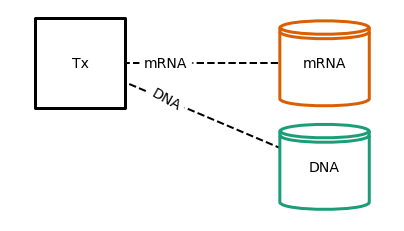

In [4]:
fig = plot_topology(Tx(), filename='tx_topology.pdf', **topology_plot_config)


#### run Tx

In [5]:
# tsc configuration
tx_config = {'time_step': 10}
tx_sim_settings = {
    'experiment_id': 'TX'}
tx_initial_state = {
    'mRNA': {'C': 0.0 * units.mg/units.mL}}
tx_plot_config = {
    'variables': [
        {
            'variable': ('mRNA', ('C', 'milligram / milliliter')),
            'color': store_colors['mRNA']
        }, 
        {
            'variable': ('DNA', ('G', 'milligram / milliliter')),
            'color': store_colors['DNA']
        }],
    'filename': 'tx_output.pdf',
    **plot_var_config}


Simulation ID: TX
Created: 10/21/2021 at 12:14:12
Completed in 0.252909 seconds
Writing out/stochastic_expression/tx_output.pdf


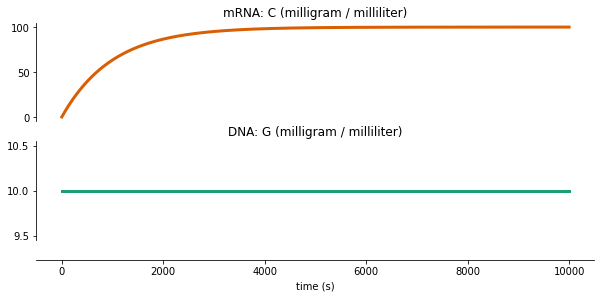

In [6]:
# initialize
tx_process = Tx(tx_config)

# make the experiment
tx_exp = process_in_experiment(
    tx_process, tx_sim_settings, tx_initial_state)

# run
tx_exp.update(10000)

# retrieve the data as a timeseries
tx_output = tx_exp.emitter.get_timeseries()

# plot
fig = plot_variables(tx_output,  **tx_plot_config)

### Tl: a deterministic translation process

Translation is the biological process by which protein is synthesized with an mRNA template.
Here, we define a model with a single protein species, $Protein_{X}$, transcribed from a single gene, $RNA_{C}$, at translation rate $k_{trl}$.
Protein also degrades at rate $k_{deg}$.

This can be represented by a chemical reaction network with the form:
* $RNA_{C} \xrightarrow[]{k_{trl}} RNA_{C} + Protein_{X} $ 
* $Protein_{X} \xrightarrow[]{k_{deg}} \emptyset$

According to [BioNumbers](https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=3&id=100043), the concentration of RNA in an *E. coli* cell is on the order of 75-120 mg/ml. The concentration of protein is 200-320 mg/ml.


In [7]:
class Tl(Process):

    defaults = {
        'ktrl': 5e-4,
        'kdeg': 5e-5}

    def ports_schema(self):
        return {
            'mRNA': {
                'C': {
                    '_default': 100 * units.mg / units.mL,
                    '_divider': 'split',
                    '_emit': True}},
            'Protein': {
                'X': {
                    '_default': 200 * units.mg / units.mL,
                    '_divider': 'split',
                    '_emit': True}}}

    def next_update(self, timestep, states):
        C = states['mRNA']['C']
        X = states['Protein']['X']
        dX = (self.parameters['ktrl'] * C - self.parameters['kdeg'] * X) * timestep
        return {
            'Protein': {
                'X': dX}}
    

#### run Tl

In [8]:
# trl configuration
tl_config = {'time_step': 10}
tl_sim_settings = {'experiment_id': 'TL'}
tl_initial_state = {
    'Protein': {'X': 0.0 * units.mg / units.mL}}
tl_plot_config = {
    'variables': [
        {
            'variable': ('Protein', ('X', 'milligram / milliliter')),
            'color': store_colors['Protein']
        },
        {
            'variable': ('mRNA', ('C', 'milligram / milliliter')),
            'color': store_colors['mRNA']
        },  
        ],
    'filename': 'tl_output.pdf',
    **plot_var_config}


Simulation ID: TL
Created: 10/21/2021 at 12:14:13
Completed in 0.258387 seconds
Writing out/stochastic_expression/tl_output.pdf


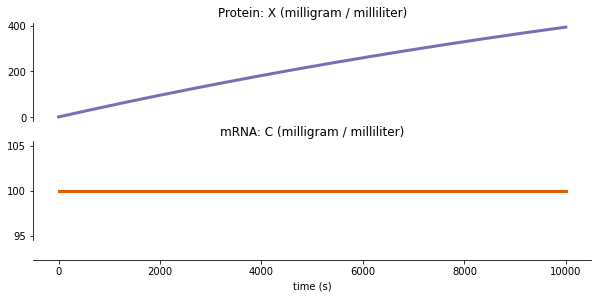

In [9]:
# initialize
tl_process = Tl(tl_config)

# make the experiment
tl_exp = process_in_experiment(
    tl_process, tl_sim_settings, tl_initial_state)

# run
tl_exp.update(10000)

# retrieve the data as a timeseries
tl_output = tl_exp.emitter.get_timeseries()

# plot
fig = plot_variables(tl_output,  **tl_plot_config)

### StochasticTx: a stochastic transcription process
This process uses the [Gillespie algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm) in its `next_update()` method.

In [10]:
class StochasticTx(Process):
    defaults = {'ktsc': 1e0, 'kdeg': 1e-3}

    def __init__(self, parameters=None):
        super().__init__(parameters)
        self.ktsc = self.parameters['ktsc']
        self.kdeg = self.parameters['kdeg']
        self.stoichiometry = np.array([[0, 1], [0, -1]])
        self.time_left = None
        self.event = None
        # initialize the next timestep
        initial_state = self.initial_state()
        self.calculate_timestep(initial_state)

    def initial_state(self, config=None):
        return {
            'DNA': {'G': 1.0},
            'mRNA': {'C': 1.0}}

    def ports_schema(self):
        return {
            'DNA': {
                'G': {
                    '_default': 1.0,
                    '_emit': True}},
            'mRNA': {
                'C': {
                    '_default': 1.0,
                    '_emit': True}}}

    def calculate_timestep(self, states):
        # retrieve the state values
        g = states['DNA']['G']
        c = states['mRNA']['C']
        array_state = np.array([g, c])

        # Calculate propensities
        propensities = [
            self.ktsc * array_state[0], self.kdeg * array_state[1]]
        prop_sum = sum(propensities)

        # The wait time is distributed exponentially
        self.calculated_timestep = np.random.exponential(scale=prop_sum)
        return self.calculated_timestep

    def next_reaction(self, x):
        """get the next reaction and return a new state"""

        propensities = [self.ktsc * x[0], self.kdeg * x[1]]
        prop_sum = sum(propensities)

        # Choose the next reaction
        r_rxn = np.random.uniform()
        i = 0
        for i, _ in enumerate(propensities):
            if r_rxn < propensities[i] / prop_sum:
                # This means propensity i fires
                break
        x += self.stoichiometry[i]
        return x

    def next_update(self, timestep, states):

        if self.time_left is not None:
            if timestep >= self.time_left:
                event = self.event
                self.event = None
                self.time_left = None
                return event

            self.time_left -= timestep
            return {}

        # retrieve the state values, put them in array
        g = states['DNA']['G']
        c = states['mRNA']['C']
        array_state = np.array([g, c])

        # calculate the next reaction
        new_state = self.next_reaction(array_state)

        # get delta mRNA
        c1 = new_state[1]
        d_c = c1 - c
        update = {
            'mRNA': {
                'C': d_c}}

        if self.calculated_timestep > timestep:
            # didn't get all of our time, store the event for later
            self.time_left = self.calculated_timestep - timestep
            self.event = update
            return {}

        # return an update
        return {
            'mRNA': {
                'C': d_c}}

### LengthFromVolume: a deriver to calculate cell length

In [11]:
from vivarium_multibody.processes.derive_globals import length_from_volume

class LengthFromVolume(Deriver):
    defaults = {'width': 1.}  # um
    def ports_schema(self):
        return {
            'global': {
                'volume': {'_default': 1 * units.fL},
                'length': {'_default': 2., '_updater': 'set'},
            }}
    def next_update(self, timestep, states):
        volume = states['global']['volume']
        length = length_from_volume(volume.magnitude, self.parameters['width'])
        return {
            'global': {
                'length': length}}

## **Composites**

### TxTl: a transcription/translation composite

We demonstrate composition by combining the `Tx` and `Tl` processes.

In [12]:
class TxTl(Composer):
    
    defaults = {
        'Tx': {'time_step': 10},
        'Tl': {'time_step': 10}}

    def generate_processes(self, config):
        return {
            'Tx': Tx(config['Tx']),
            'Tl': Tl(config['Tl'])}

    def generate_topology(self, config):
        return {
            'Tx': {
                'DNA': ('DNA',),
                'mRNA': ('mRNA',)},
            'Tl': {
                'mRNA': ('mRNA',),
                'Protein': ('Protein',)}}
    

#### plot TxTl topology

Writing out/stochastic_expression/txtl_topology.pdf


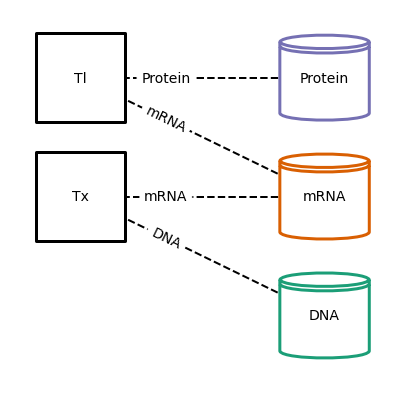

In [13]:
txtl_topology_plot_config = copy.deepcopy(topology_plot_config)
txtl_topology_plot_config['settings']['node_distance'] = 2
fig = plot_topology(TxTl(), filename='txtl_topology.pdf', **topology_plot_config)

#### run TxTl

In [14]:
# tsc_trl configuration
txtl_config = {}
txtl_exp_settings = {'experiment_id': 'TXTL'}
txtl_plot_config = {
    'variables':[
        {
            'variable': ('Protein', ('X', 'milligram / milliliter')),
            'color': store_colors['Protein']
        },
        {
            'variable': ('mRNA', ('C', 'milligram / milliliter')),
            'color': store_colors['mRNA']
        },
        {
            'variable': ('DNA', ('G', 'milligram / milliliter')), 
            'color': store_colors['DNA']
        },
    ],
    'filename': 'txtl_output.pdf',
    **plot_var_config}
tl_initial_state = {
    'mRNA': {'C': 0.0 * units.mg / units.mL},
    'Protein': {'X': 0.0 * units.mg / units.mL}}


Simulation ID: TXTL
Created: 10/21/2021 at 12:14:14
Completed in 0.721458 seconds
Writing out/stochastic_expression/txtl_output.pdf


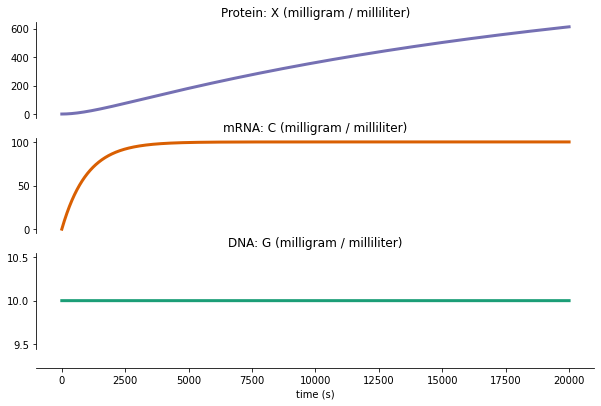

In [15]:
# construct TxTl
txtl_composite = TxTl(txtl_config)

# make the experiment
txtl_experiment = composer_in_experiment(
    txtl_composite, txtl_exp_settings, tl_initial_state)

# run it and retrieve the data that was emitted to the simulation log
txtl_experiment.update(20000)
txtl_output = txtl_experiment.emitter.get_timeseries()

# plot the output
fig = plot_variables(txtl_output, **txtl_plot_config)

### Combining stochastic Tx with deterministic Tl

In [16]:
# configuration data
mw_config = {'C': 1e8 * units.g / units.mol}

In [17]:
  
class StochasticTxTl(Composer):
    defaults = {
        'stochastic_Tx': {},
        'Tl': {'time_step': 1},
        'concs': {
            'molecular_weights': mw_config}}
    
    def generate_processes(self, config):
        counts_to_concentration = process_registry.access('counts_to_concentration')
        return {
            'stochastic\nTx': StochasticTx(config['stochastic_Tx']),
            'Tl': Tl(config['Tl']),
            'counts\nto\nmg/mL': counts_to_concentration(config['concs'])}

    def generate_topology(self, config):
        return {
            'stochastic\nTx': {
                'DNA': ('DNA\n(counts)',),
                'mRNA': ('mRNA\n(counts)',)
            },
            'Tl': {
                'mRNA': ('mRNA\n(mg/mL)',),
                'Protein': ('Protein\n(mg/mL)',)
            },
            'counts\nto\nmg/mL': {
                'global': ('boundary',),
                'input': ('mRNA\n(counts)',),
                'output': ('mRNA\n(mg/mL)',)
            }}
    

#### plot StochasticTxTl topology

Writing out/stochastic_expression/stochastic_txtl_topology.pdf


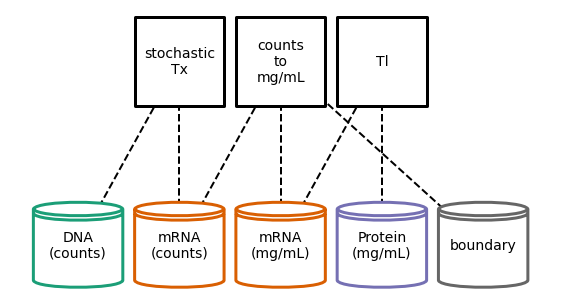

In [18]:
# plot topology after merge
stochastic_topology_plot_config = copy.deepcopy(topology_plot_config)
stochastic_topology_plot_config['settings']['graph_format'] = 'horizontal'
stochastic_topology_plot_config['settings']['coordinates'] = {
    'stochastic\nTx': (2, 1),
    'counts\nto\nmg/mL': (3, 1),
    'Tl': (4, 1),
    'DNA\n(counts)': (1,-1),
    'mRNA\n(counts)': (2,-1),
    'mRNA\n(mg/mL)': (3,-1),
    'Protein\n(mg/mL)': (4,-1)}
stochastic_topology_plot_config['settings']['dashed_edges'] = True
stochastic_topology_plot_config['settings']['show_ports'] = False
stochastic_topology_plot_config['settings']['node_distance'] = 2.2


stochastic_txtl = StochasticTxTl()
fig = plot_topology(
    stochastic_txtl, 
    filename='stochastic_txtl_topology.pdf', 
    **stochastic_topology_plot_config)

#### run StochasticTxTl


Simulation ID: stochastic_txtl
Created: 10/21/2021 at 12:14:17
Completed in 0.749710 seconds
Writing out/stochastic_expression/stochastic_txtl_output.pdf


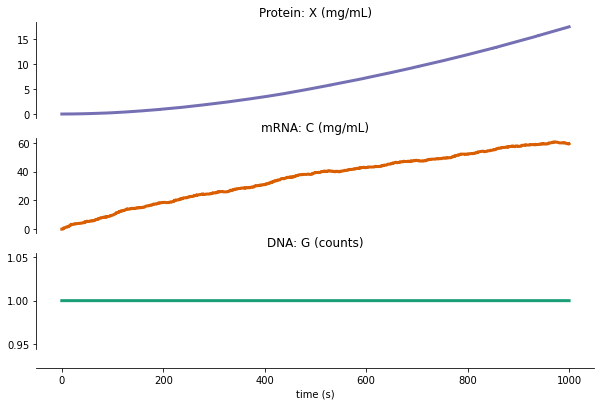

In [19]:
# make the experiment
stoch_experiment = composer_in_experiment(stochastic_txtl, **stoch_exp_settings)

# simulate and retrieve the data
stoch_experiment.update(1000)
stochastic_txtl_output = stoch_experiment.emitter.get_timeseries()

# plot output
fig = plot_variables(stochastic_txtl_output, **stoch_plot_config)

## **Embedding in a Hierarchy**

We here extend the Transcription/Translation model with division. This require many instances of the processes to run simultaneously in a single simulation. To support such phenomena, Vivarium adopts an agent-based modeling bigraphical formalism, with embedded compartments that can spawn new compartments during runtime. 

### TxTlDivision Composite

In [20]:
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision
from vivarium.processes.growth_rate import GrowthRate

TIMESTEP = 10


class TxTlDivision(Composer):
    defaults = {
        'time_step': TIMESTEP,
        'stochastic_Tx': {},
        'Tl': {},
        'concs': {
            'molecular_weights': {
                'C': 1e8 * units.g / units.mol}},
        'growth': {
            'time_step': 1,
            'default_growth_rate': 0.0005,
            'default_growth_noise': 0.001,
            'variables': ['volume']},
        'agent_id': np.random.randint(0, 100),
        'divide_condition': {
            'threshold': 2.5 * units.fL},
        'agents_path': ('..', '..', 'agents',),
        'boundary_path': ('boundary',),
        'daughter_path': tuple(),
        '_schema': {
            'concs': {
                'input': {'C': {'_divider': 'binomial'}},
                'output': {'C': {'_divider': 'set'}},
            }}}

    def generate_processes(self, config):
        counts_to_concentration = process_registry.access('counts_to_concentration')
        division_config = dict(
            daughter_path=config['daughter_path'],
            agent_id=config['agent_id'],
            composer=self)
        time_step_config = {'time_step': config['time_step']}
        return {
            'stochastic_Tx': StochasticTx({**config['stochastic_Tx'], **time_step_config}),
            'Tl': Tl({**config['Tl'], **time_step_config}),
            'concs': counts_to_concentration(config['concs']),
            'growth': GrowthRate({**config['growth'], **time_step_config}),
            'divide_condition': DivideCondition(config['divide_condition']),
            'shape': LengthFromVolume(),
            'division': MetaDivision(division_config)}

    def generate_topology(self, config):
        boundary_path = config['boundary_path']
        agents_path = config['agents_path']
        return {
            'stochastic_Tx': {
                'DNA': ('DNA',),
                'mRNA': ('RNA_counts',)},
            'Tl': {
                'mRNA': ('RNA',),
                'Protein': ('Protein',)},
            'concs': {
                'global': boundary_path,
                'input': ('RNA_counts',),
                'output': ('RNA',)},
            'growth': {
                'variables': boundary_path,
                'rates': ('rates',)},
            'divide_condition': {
                'variable': boundary_path + ('volume',),
                'divide': boundary_path + ('divide',)},
            'shape': {
                'global': boundary_path,
            },
            'division': {
                'global': boundary_path,
                'agents': agents_path}}


In [21]:
# configure hierarchy
agent_id = '0'

# initial state
hierarchy_initial_state = {
    'agents': {
        agent_id: {
            'boundary': {'volume': 1.2 * units.fL},
            'DNA': {'G': 1},
            'RNA': {'C': 5 * units.mg / units.mL},
            'Protein': {'X': 50 * units.mg / units.mL}}}}


# make a txtl composite, embedded under an 'agents' store
txtl_composer = TxTlDivision({})
txtl_composite = txtl_composer.generate({'agent_id': agent_id}, path=('agents', agent_id))

#### plot topology before division

Writing out/stochastic_expression/txtl_hierarchy_topology.pdf


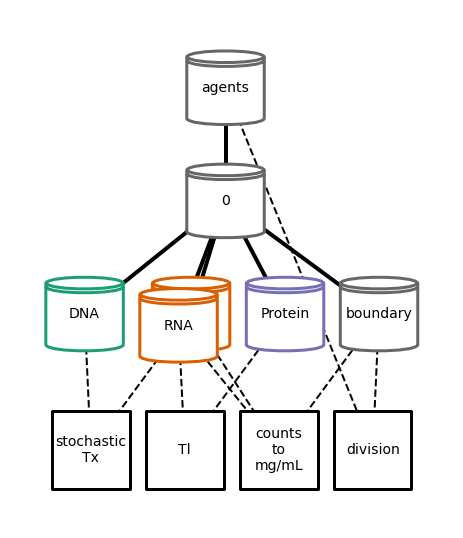

In [22]:
fig = plot_topology(
    txtl_composite, 
    filename='txtl_hierarchy_topology.pdf', 
    **hierarchy_topology_plot_config)

#### plot topology after division

In [23]:
# initial state
initial_state = {
    'agents': {
        agent_id: {
            'boundary': {'volume': 1.2 * units.fL},
            'DNA': {'G': 1},
            'RNA': {'C': 5 * units.mg / units.mL},
            'Protein': {'X': 50 * units.mg / units.mL}}}}

# experiment settings
exp_settings = {
    'experiment_id': 'hierarchy_experiment',
    'initial_state': initial_state,
    'emit_step': 100.0}

# make a copy of the composite
txtl_composite1 = copy.deepcopy(txtl_composite)

# make the experiment
settings = {}
hierarchy_experiment1 = composite_in_experiment(
    composite=txtl_composite1, 
    settings=exp_settings, 
    initial_state=initial_state)

# run the experiment long enough to divide
hierarchy_experiment1.update(2000)


Simulation ID: hierarchy_experiment
Created: 10/21/2021 at 12:14:19
Completed in 1.25 seconds


Writing out/stochastic_expression/hierarchy_topology_2.pdf


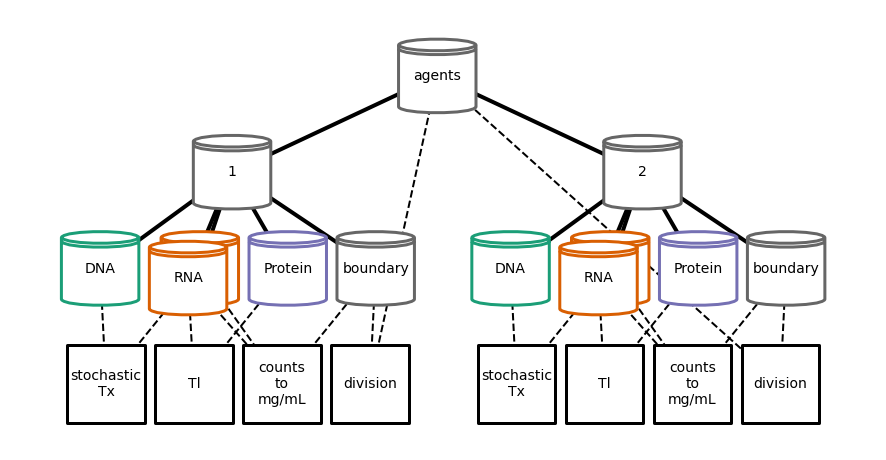

In [24]:
fig = plot_topology(
    txtl_composite1, 
    filename='hierarchy_topology_2.pdf', 
    **hierarchy_topology_plot_config2)

#### run hierarchy experiment

In [25]:
hierarchy_experiment_total_time = 5000

# initial state
hierarchy_experiment_initial_state = {
    'agents': {
        agent_id: {
            'boundary': {'volume': 1.2 * units.fL},
            'DNA': {'G': 1},
            'RNA': {'C': 5 * units.mg / units.mL},
            'Protein': {'X': 50 * units.mg / units.mL}}}}

# make a copy of the composite
txtl_composite2 = copy.deepcopy(txtl_composite)

# make the experiment
settings = {}
hierarchy_experiment = composite_in_experiment(
    composite=txtl_composite2,
    settings=exp_settings,
    initial_state=hierarchy_experiment_initial_state)

# run the experiment
hierarchy_experiment.update(hierarchy_experiment_total_time)


Simulation ID: hierarchy_experiment
Created: 10/21/2021 at 12:14:21
Completed in 17.30 seconds


#### plot output

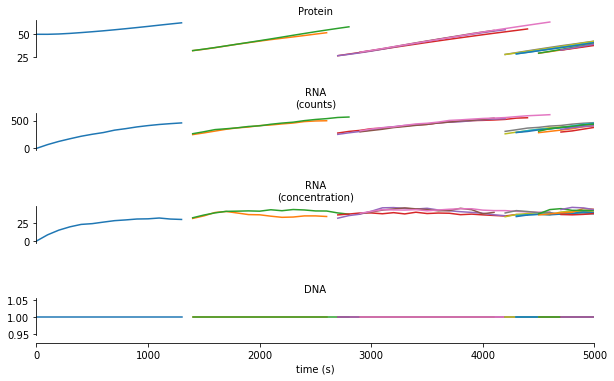

In [26]:
# retrieve the data
hierarchy_data = hierarchy_experiment.emitter.get_data_unitless()

# initialize the plot
multigen_fig = plot_agents_multigen(hierarchy_data, hierarchy_plot_settings)

## **Spatial Environment**

In [27]:
from vivarium_multibody.composites.lattice import (
    Lattice, make_lattice_config)
from vivarium_multibody.plots.snapshots import (
    plot_snapshots, plot_tags, make_tags_figure, format_snapshot_data)
from vivarium_multibody.plots.snapshots_video import make_video
from vivarium.core.composition import simulate_composite
from vivarium.library.units import remove_units

Loading chipmunk for Darwin (64bit) [/Users/eranagmon/.pyenv/versions/3.8.3/envs/vivarium_project/lib/python3.8/site-packages/pymunk/libchipmunk.dylib]


#### use composite.merge to combine Lattice processes with agents

In [28]:
lattice_time_step = 10
bins = [10, 10]
bounds = [20, 20]

# make the lattice environment
lattice_config = make_lattice_config(
    n_bins=bins,
    bounds=bounds,
    depth=10,
    jitter_force=5e-5,
    time_step=lattice_time_step,
)

# make the composers
lattice_composer = Lattice(lattice_config)
txtl_composer = TxTlDivision({'time_step': lattice_time_step})

#### plot topology with Lattice composite

Writing out/stochastic_expression/lattice_topology.pdf


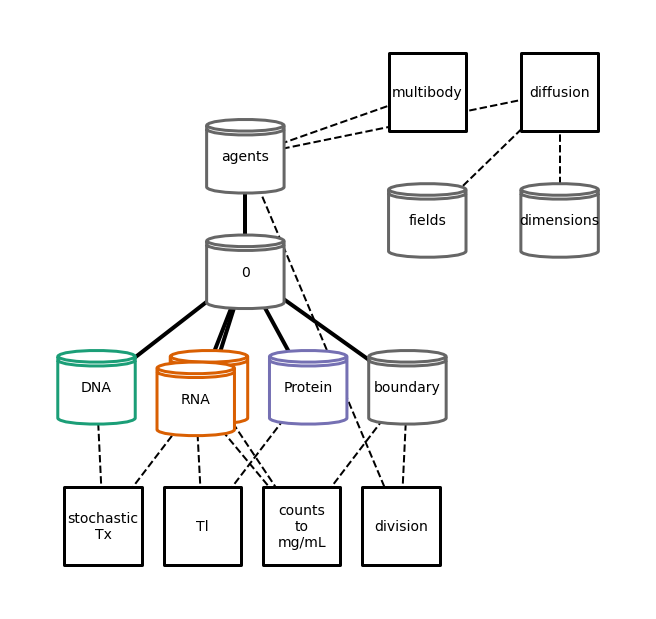

In [29]:
agent_id = '0'
lattice_composite = lattice_composer.generate()
agent = txtl_composer.generate({'agent_id': agent_id})
lattice_composite.merge(composite=agent, path=('agents', agent_id))    

lattice_topology_plot_config = copy.deepcopy(hierarchy_topology_plot_config)
lattice_topology_plot_config['settings']['node_distance'] = 3
lattice_topology_plot_config['settings']['coordinates']['fields'] = (2.5, -0.5)
lattice_topology_plot_config['settings']['coordinates']['dimensions'] = (3.5, -0.5)
lattice_topology_plot_config['settings']['coordinates']['multibody'] = (2.5, 0.5)
lattice_topology_plot_config['settings']['coordinates']['diffusion'] = (3.5, 0.5)
lattice_topology_plot_config['settings']['remove_nodes'].append('agents\n0\nboundary\nexternal')
fig = plot_topology(lattice_composite, filename='lattice_topology.pdf', **lattice_topology_plot_config)

#### run the simulation

In [37]:
total_time = 3000
agent_id = '0'

# make the composites
# embed txtl under an 'agents' store
lattice_composite = lattice_composer.generate()
agent = txtl_composer.generate({'agent_id': agent_id})
lattice_composite.merge(composite=agent, path=('agents', agent_id))    

# initial state
lattice_experiment_initial_state = {
    'agents': {
        agent_id: {
            'boundary': {'volume': 1.2 * units.fL},
            'DNA': {'G': 1},
            'RNA_counts': {'C': 1},
#             'RNA': {'C': 5 * units.mg / units.mL},
            'Protein': {'X': 50 * units.mg / units.mL}}}}

# run simulation  
sim_settings = {
    'progress_bar': False,
    'initial_state': lattice_experiment_initial_state,
}
experiment = composite_in_experiment(lattice_composite, sim_settings)
experiment.update(total_time)

# extract data
lattice_data = experiment.emitter.get_data_deserialized()
lattice_data = remove_units(lattice_data)
del lattice_data[0.0]


Simulation ID: 63a28d3a-32a3-11ec-8419-acde48001122
Created: 10/21/2021 at 12:16:27
Completed in 5.05 seconds


#### make tags plot

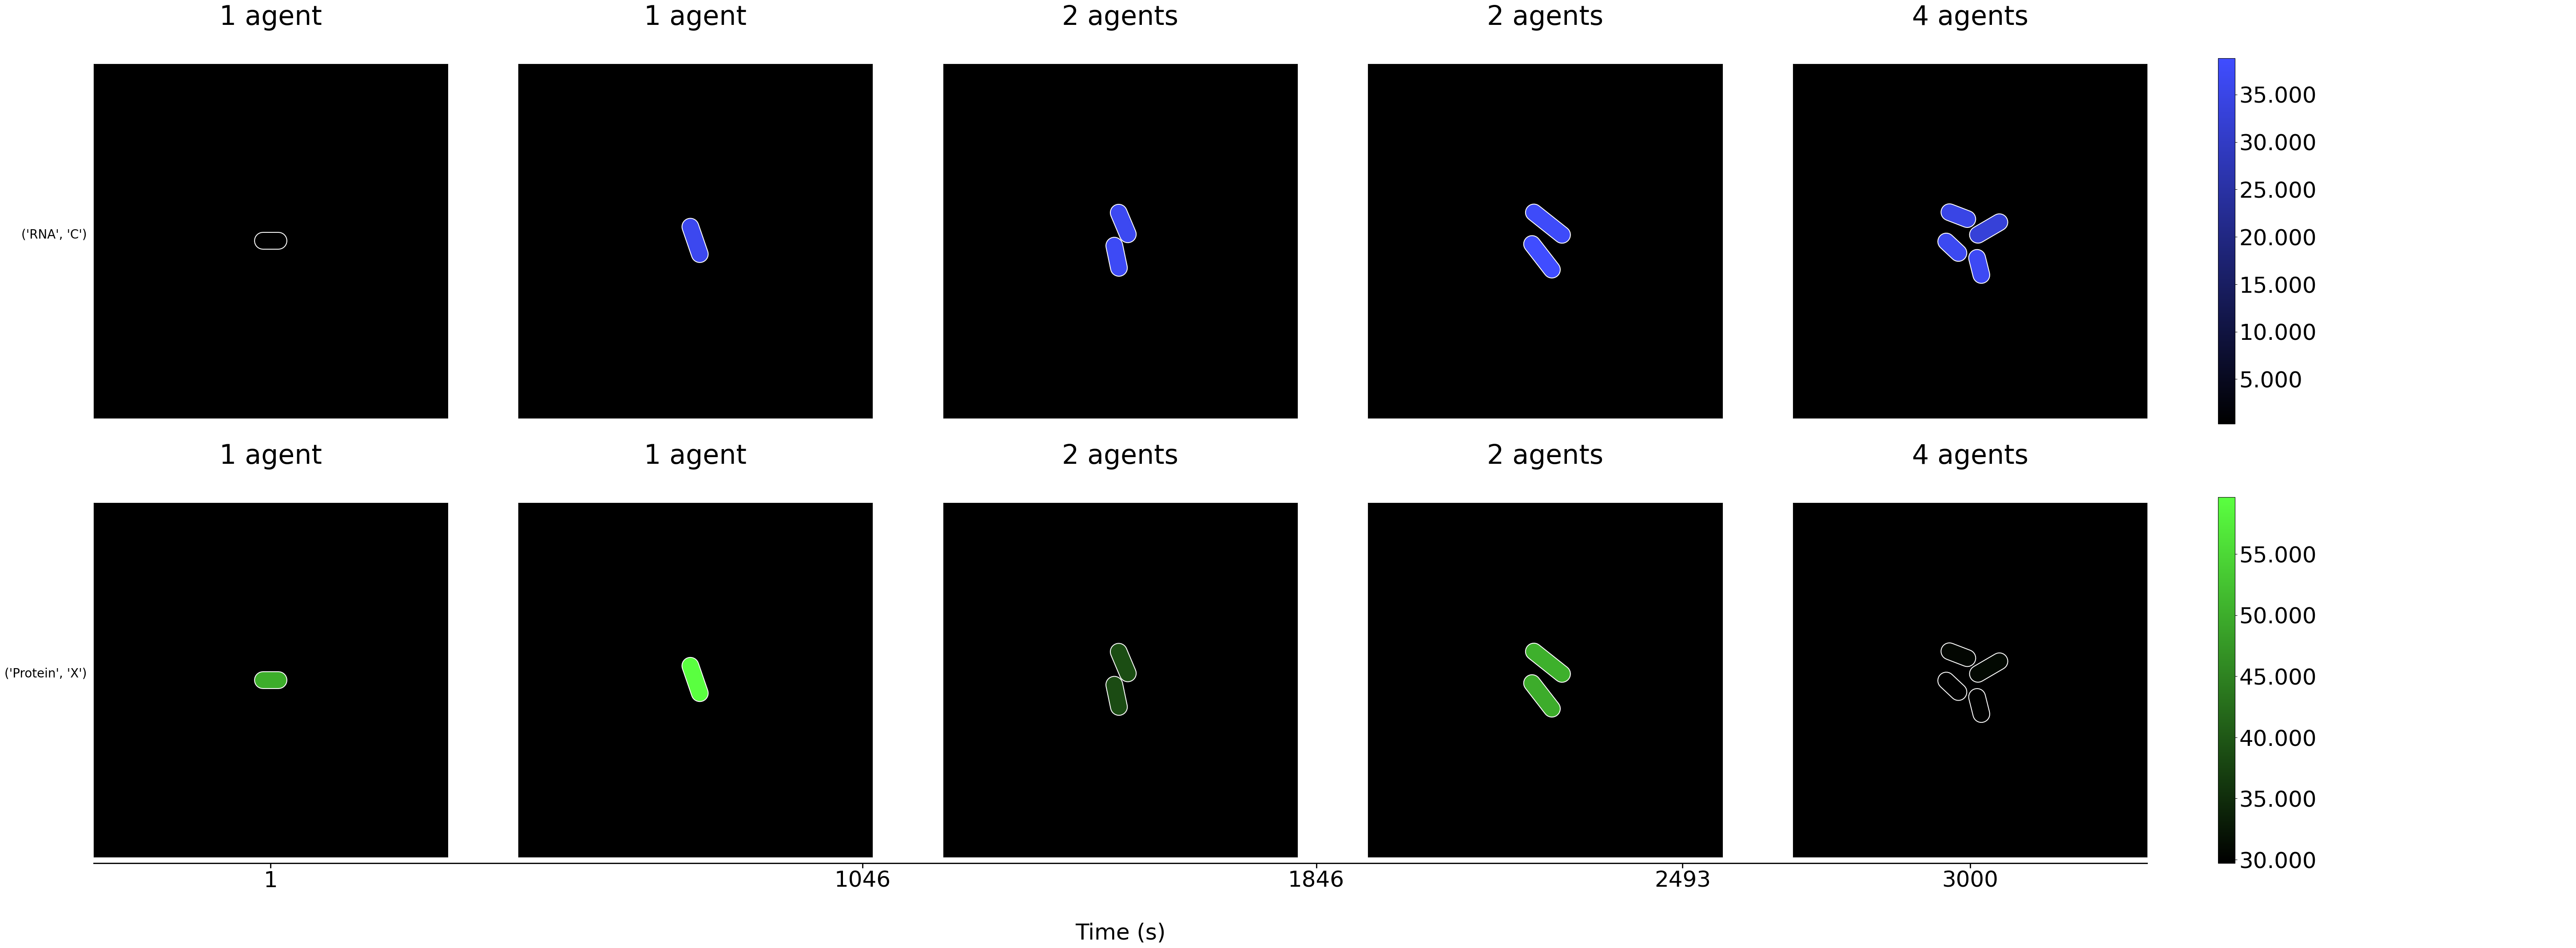

In [38]:
n_snapshots = 5
tagged_molecules = [        
        ('RNA', 'C'),
        ('Protein', 'X'),
    ]

# format the data for plot_snapshots
lattice_agents, fields = format_snapshot_data(lattice_data)
time_vec = list(lattice_agents.keys())
time_indices = np.round(np.linspace(0, len(time_vec) - 1, n_snapshots)).astype(int)
snapshot_times = [time_vec[i] for i in time_indices]

fig = make_tags_figure(
    agents=lattice_agents,
    bounds=bounds,
    n_snapshots=n_snapshots,
    time_indices=time_indices,
    snapshot_times=snapshot_times,
    convert_to_concs=False,
    tagged_molecules=tagged_molecules,
#     out_dir=OUTDIR,
#     filename='tags'
)

#### save video

In [39]:
tagged_molecules = [        
        ('RNA_counts', 'C'),
        ('Protein', 'X'),
    ]
# del lattice_data[0.0]

make_video(
    lattice_data,
    bounds,
    plot_type='tags',
    step=40,  # render every nth snapshot
    tagged_molecules=tagged_molecules,
    convert_to_concs=True,
    out_dir=OUTDIR,
    filename='snapshots_video',
)

ValueError: RGBA values should be within 0-1 range

ValueError: RGBA values should be within 0-1 range

<Figure size 1400x1400 with 7 Axes>